# 0.0 Imports

In [29]:
import pandas as pd 
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings("ignore")


  # 0.1 Helper Functions
  

In [30]:
def limites(coluna):
    q1= coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3-q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude 
def excluir_outliers(df,nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf,lim_sup = limites(df[nome_coluna])
    df= df.loc[(df[nome_coluna]>= lim_inf) & (df[nome_coluna] <= lim_sup),:]
    linhas_removidas = qtd_linhas - df.shape[0]
    return df,linhas_removidas
def diagrama_caixa(coluna):
    fig,(ax1,ax2) =plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna,ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna,ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.histplot(coluna)
    plt.show()
    
def grafico_barras(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index,y=coluna.value_counts())
    ax.set_xlim(limites(coluna))
    plt.show()

def avaliar_modelo(nome_modelo,y_teste,previsoes):
    r2 = r2_score(y_teste,previsoes)
    RMSE = np.sqrt(mean_squared_error(y_teste,previsoes))
    return (f"Modelo {nome_modelo}:\nR2:{r2}\nRMSE:{RMSE}")

# 0.2 Loading Data

In [3]:
caminho = Path("dataset") 
arquivos = caminho.iterdir()
dataset = pd.DataFrame()
meses={"jan":1,"fev":2,"mar":3,"abr":4,"mai":5,"jun":6,"jul":7,"ago":8,"set":9,"out":10,"nov":11,"dez":12}
for arquivo in arquivos:
    nome_mes = arquivo.name[0:3]
    mes = meses[nome_mes]
    ano = arquivo.name[-8:]
    ano = int(ano.replace(".csv",""))     
    df = pd.read_csv(caminho/arquivo.name,low_memory=False)
    df["mes"] = mes
    df["ano"] = ano    
    dataset = dataset.append(df)


In [4]:
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902210 entries, 0 to 34328
Columns: 108 entries, id to calculated_host_listings_count_shared_rooms
dtypes: float64(31), int64(15), object(62)
memory usage: 5.7 GB


# 1.0 Data Description

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [5]:
print(list(dataset.columns))
#dataset.head(1000).to_csv("primeiros_mil_regristros.csv",sep=";", index=False)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [6]:
colunas = ["host_response_time","host_response_rate","host_is_superhost","host_listings_count","latitude","longitude","property_type","room_type","accommodates","bathrooms","bedrooms","beds","bed_type","amenities","square_feet","price","cleaning_fee","guests_included","extra_people","minimum_nights","has_availability","number_of_reviews","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","instant_bookable","is_business_travel_ready","cancellation_policy","mes","ano"]


In [7]:
df1 = dataset[colunas]
df1.head()

host_response_time host_response_rate host_is_superhost  \
0                NaN                NaN                 f   
1     within an hour               100%                 t   
2     within an hour               100%                 f   
3     within an hour               100%                 f   
4     within an hour               100%                 t   

   host_listings_count   latitude  longitude property_type        room_type  \
0                  1.0 -22.946854 -43.182737     Apartment  Entire home/apt   
1                  2.0 -22.965919 -43.178962   Condominium  Entire home/apt   
2                  1.0 -22.985698 -43.201935     Apartment  Entire home/apt   
3                  3.0 -22.977117 -43.190454     Apartment  Entire home/apt   
4                  1.0 -22.983024 -43.214270     Apartment  Entire home/apt   

   accommodates  bathrooms  ...  review_scores_cleanliness  \
0             4        1.0  ...                        9.0   
1             5        1.0  ...                        9.0   
2             2        1.0  ...                       10.0   
3             3        1.0  ...                       10.0   
4             3        1.0  ...                       10.0   

   review_scores_checkin review_scores_communication review_scores_location  \
0                    9.0                         9.0                    9.0   
1                   10.0                        10.0                    9.0   
2                   10.0                        10.0                   10.0   
3                   10.0                        10.0                   10.0   
4                   10.0                        10.0                   10.0   

   review_scores_value instant_bookable is_business_travel_ready  \
0                  9.0                f                        f   
1                  9.0                t                        f   
2                  9.0                f                        f   
3                  9.0                f                        f   
4                  9.0                t                        f   

           cancellation_policy mes   ano  
0  strict_14_with_grace_period   4  2018  
1                       strict   4  2018  
2                       strict   4  2018  
3                       strict   4  2018  
4                       strict   4  2018  

[5 rows x 34 columns]

# 1.1 Data Dimension

In [8]:
print("Number of rows {}".format(df1.shape[0]))
print("Number of columns {}".format(df1.shape[1]))

Number of rows 902210
Number of columns 34


# 1.2 Data Dtypes

In [9]:
df1.dtypes

host_response_time              object
host_response_rate              object
host_is_superhost               object
host_listings_count            float64
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
amenities                       object
square_feet                    float64
price                           object
cleaning_fee                    object
guests_included                  int64
extra_people                    object
minimum_nights                   int64
has_availability                object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

# 1.3 Check NAN

In [10]:
#(df1.isnull().sum() / len(df1) ).sort_values(ascending=False)
df1.isnull().sum().sort_values(ascending=False)

square_feet                    888162
review_scores_checkin          448650
review_scores_accuracy         448586
review_scores_location         448553
review_scores_value            448551
review_scores_communication    448415
review_scores_cleanliness      448413
review_scores_rating           448016
host_response_rate             401846
host_response_time             401843
cleaning_fee                   313506
beds                             2502
bathrooms                        1724
bedrooms                          850
host_listings_count               460
host_is_superhost                 460
number_of_reviews                   0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
mes                                 0
guests_included                     0
has_availability                    0
minimum_nights                      0
extra_people                        0
price                               0
amenities   

In [11]:
filtro = df1.isnull().sum() < 300000
df1 = df1.loc[:,filtro]


In [12]:
df1.isnull().sum()

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
has_availability               0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
mes                            0
ano                            0
dtype: int64

In [13]:
df1.dropna(inplace=True)

# 1.4 Change Data Types

In [14]:
print(df1.iloc[0])

host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [15]:
df1["price"] = df1["price"].str.replace("$","").str.replace(",","").astype(np.float32,copy=False)
df1["extra_people"] = df1["extra_people"].str.replace("$","").str.replace(",","").astype(np.float32,copy=False)

# 1.5 Descriptive Statistics


In [16]:
num_attributes = df1.select_dtypes(include=["float","int"])
cat_attributes = df1.select_dtypes(include=["float","int"])

In [17]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

attributes         min            max          range  \
0   host_listings_count     0.00000    1495.000000    1495.000000   
1              latitude   -23.07340     -22.748953       0.324447   
2             longitude   -43.73892     -43.103709       0.635211   
3          accommodates     1.00000     160.000000     159.000000   
4             bathrooms     0.00000     200.000000     200.000000   
5              bedrooms     0.00000      45.000000      45.000000   
6                  beds     0.00000      86.000000      86.000000   
7                 price     0.00000  138288.000000  138288.000000   
8       guests_included     1.00000      36.000000      35.000000   
9          extra_people     0.00000    5631.000000    5631.000000   
10       minimum_nights     1.00000    1224.000000    1223.000000   
11    number_of_reviews     0.00000     401.000000     401.000000   
12                  mes     1.00000      12.000000      11.000000   
13                  ano  2018.00000    2020.000000       2.000000   

           mean       median          std       skew     kurtosis  
0      8.540508     1.000000    47.083930  18.629306   497.105809  
1    -22.965346   -22.970675     0.034776   1.063655     2.799617  
2    -43.253856   -43.200070     0.097373  -1.284455     0.605854  
3      4.211794     4.000000     2.613926   7.375498   356.139292  
4      1.695061     1.000000     1.197991  42.275932  6698.930223  
5      1.645698     1.000000     1.078560   2.502485    37.027525  
6      2.601979     2.000000     2.069425   4.795431    69.162973  
7    647.922241   297.000000  1705.997192  14.819809   381.012360  
8      1.677594     1.000000     1.529590   3.376704    16.122083  
9     40.158710     0.000000    98.540741   8.278687   162.828064  
10     4.559410     2.000000    20.889117  30.945076  1253.906521  
11     7.730099     1.000000    21.819145   5.628429    43.783613  
12     6.326888     6.000000     3.398322   0.122732    -1.195721  
13  2018.862824  2019.000000     0.716148   0.208187    -1.040615

# 1.6 Análise Exploratória dos Dados e Tratamento de Outliers
 
- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

## 1.6.1 Análise Univariada

### 1.6.1. Response Variable

<AxesSubplot: xlabel='price'>

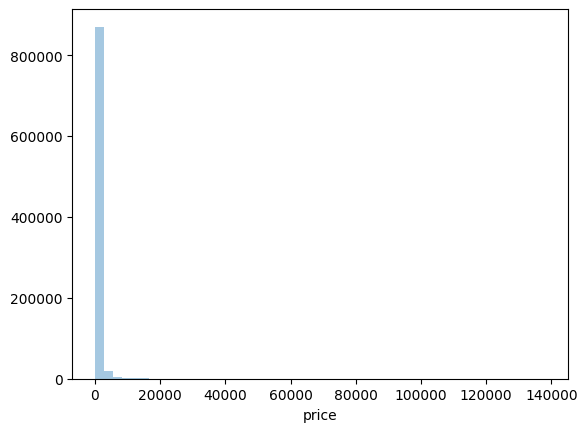

In [19]:
sns.distplot( df1['price'], kde=False  )

<AxesSubplot: xlabel='price', ylabel='Density'>

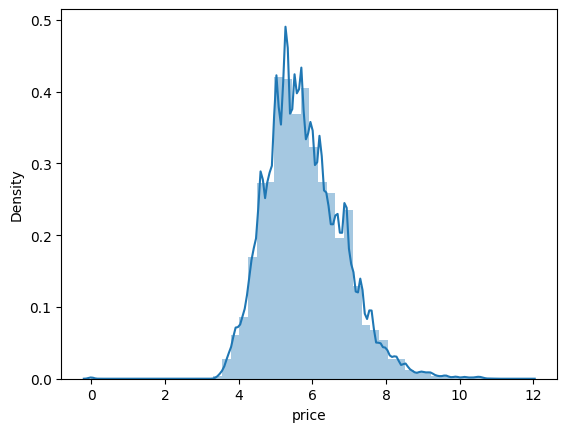

In [20]:
sns.distplot( np.log1p(df1["price"]) )

# 1.6.2 Analise Multivariada

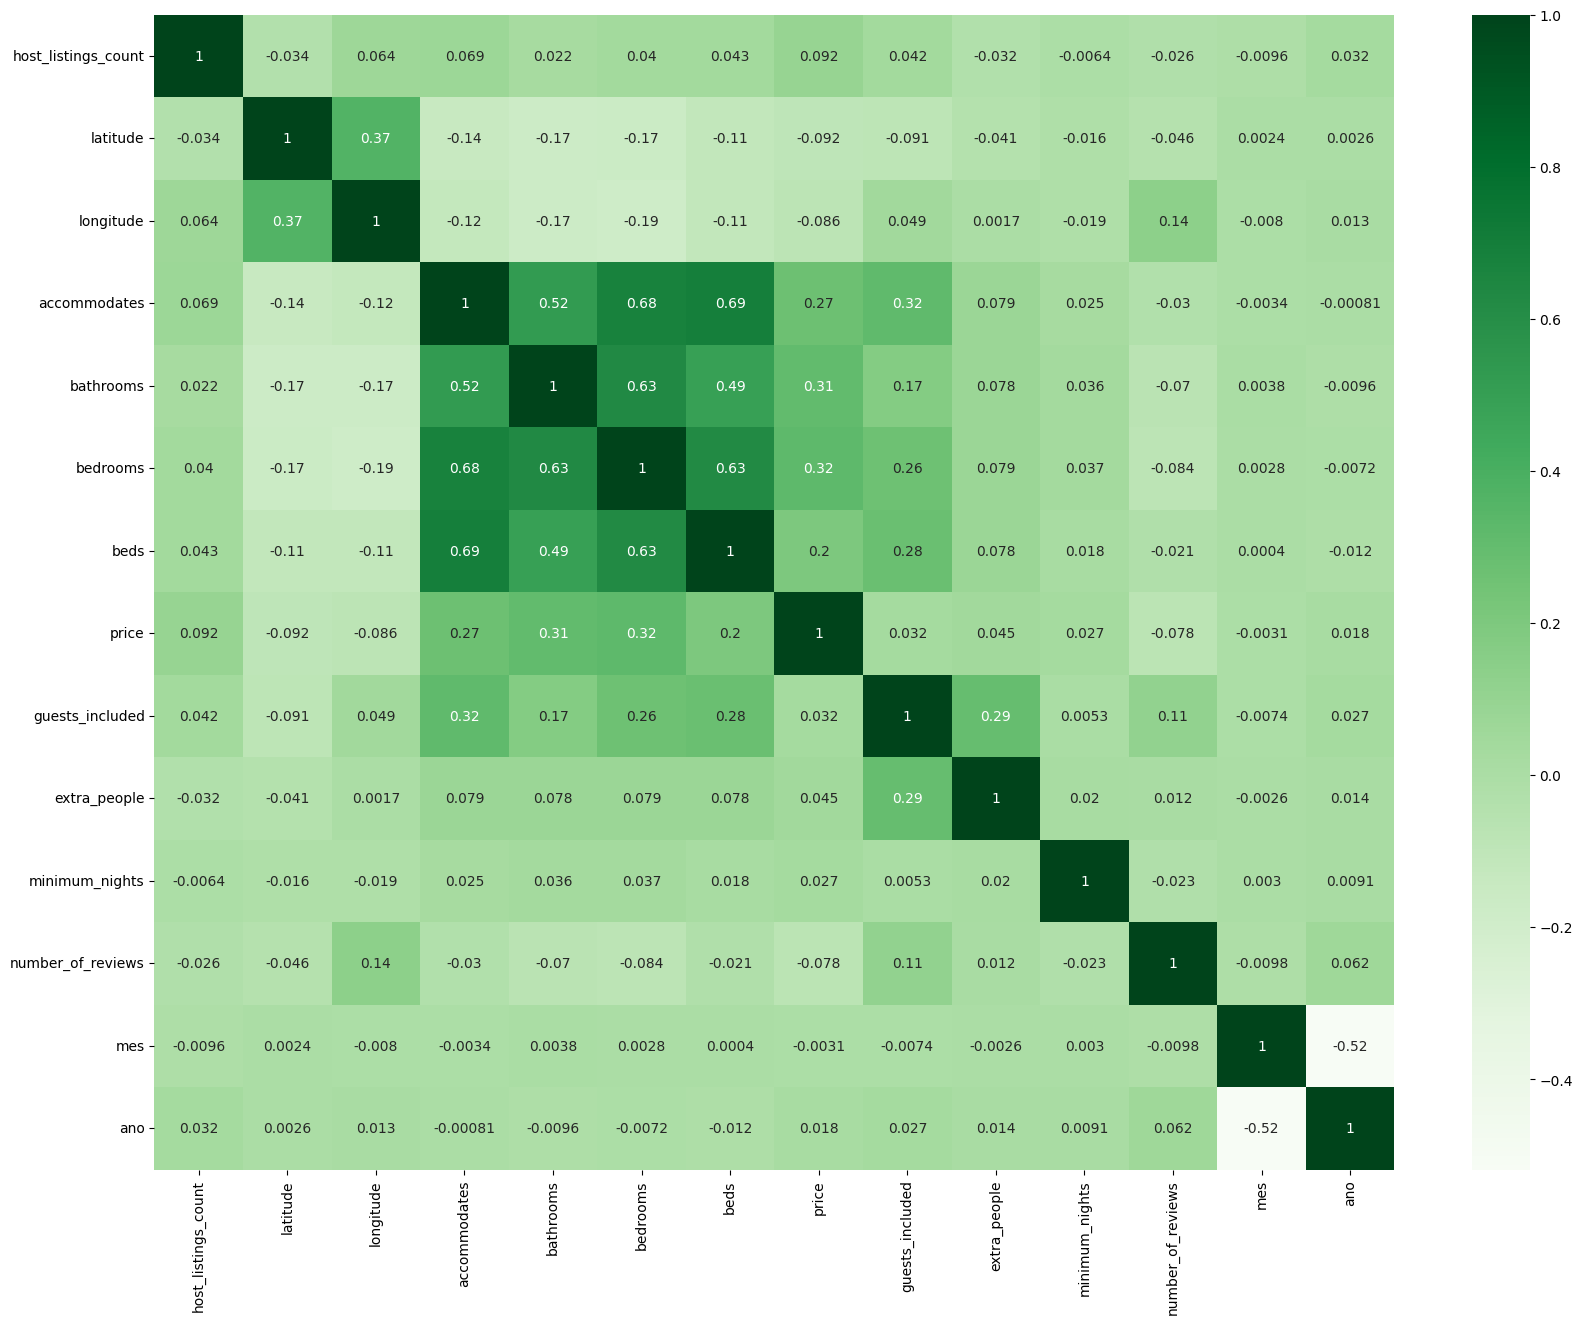

In [21]:
plt.figure(figsize=(20,15))
sns.heatmap(df1.corr(),annot=True,cmap="Greens")
plt.show()

In [22]:
# Q1 = np.quantile(dataset_filtrado["price"],.25)
# Q3 = np.quantile(dataset_filtrado["price"],.75)
# amplitude = Q3 - Q1
# limite_inferior = Q1 - 1.5 * amplitude 
# limite_superior = Q3 + 1.5 * amplitude
# #print(limite_inferior,limite_superior)
# outlier = []
# for i,preco in enumerate(dataset_filtrado["price"]):
#     if preco > limite_superior:
#         outlier.append(preco) 

## 1.7 Outliers

## 1.7.1 Price

In [23]:
limites(df1.price)

(-524.0, 1276.0)

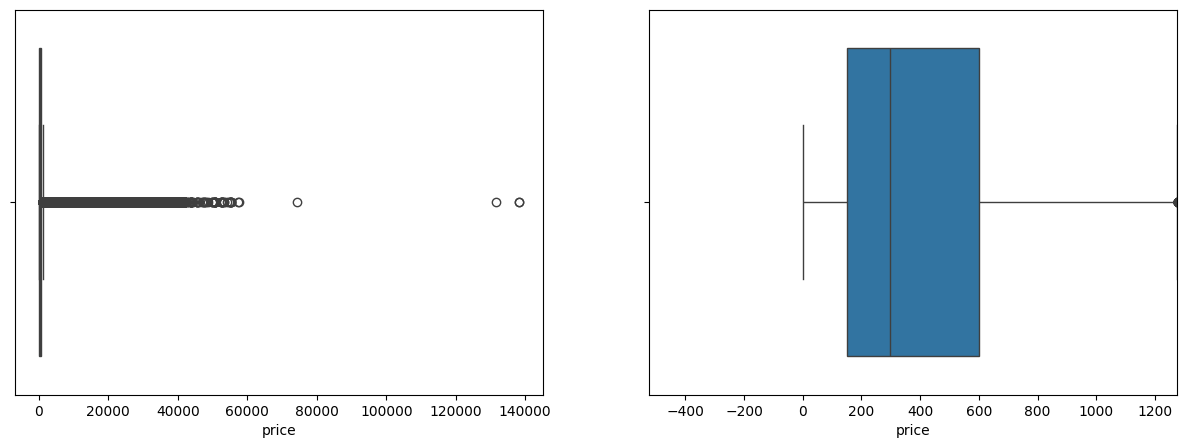

In [24]:
diagrama_caixa(df1.price)

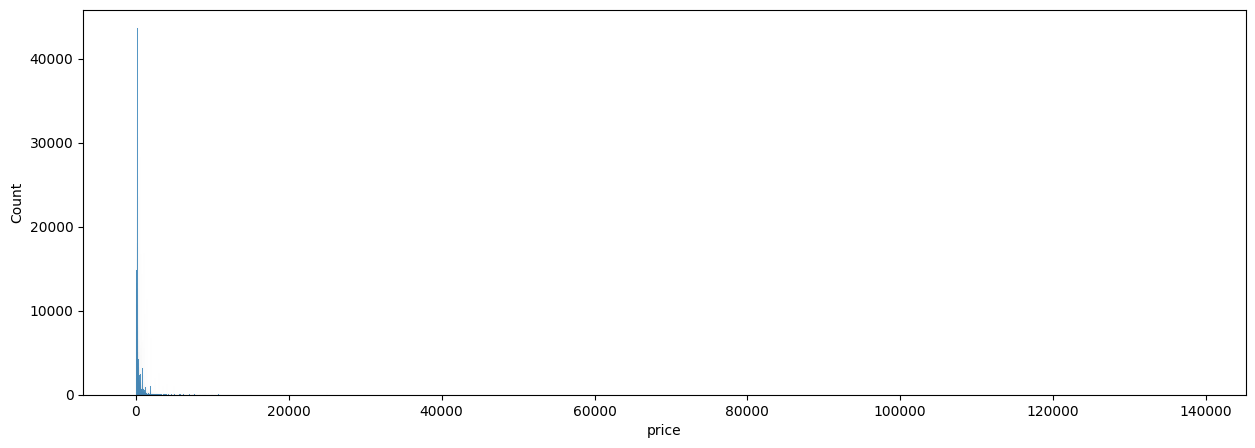

In [25]:
histograma(df1.price)

In [26]:
df1,linhas_removidas = excluir_outliers(df1,"price")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 87282


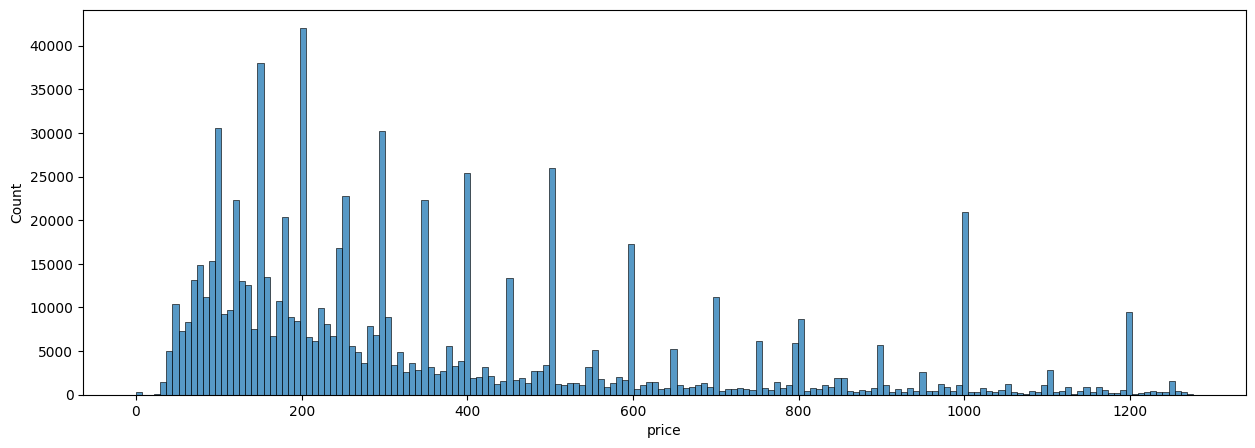

In [27]:
histograma(df1.price)

### 1.7.2 Extra_People

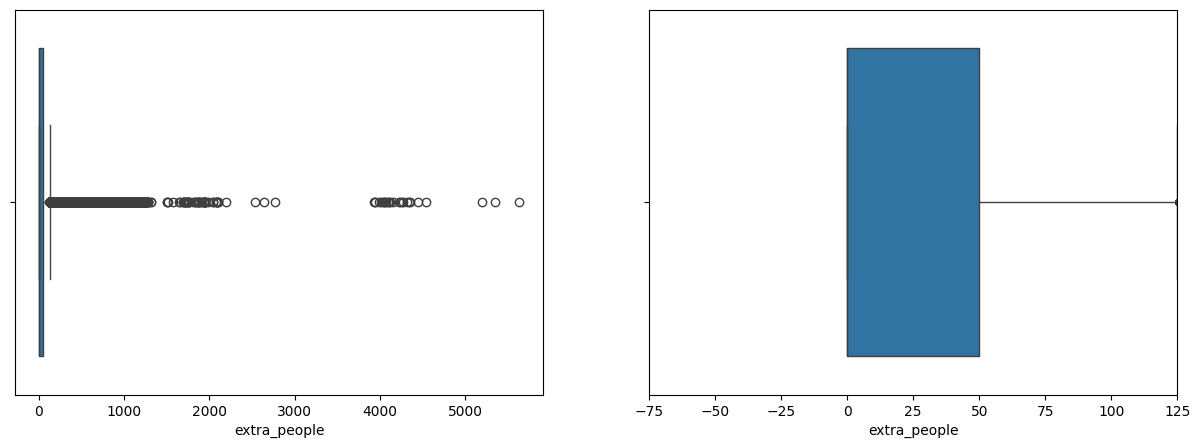

In [28]:
diagrama_caixa(df1.extra_people)

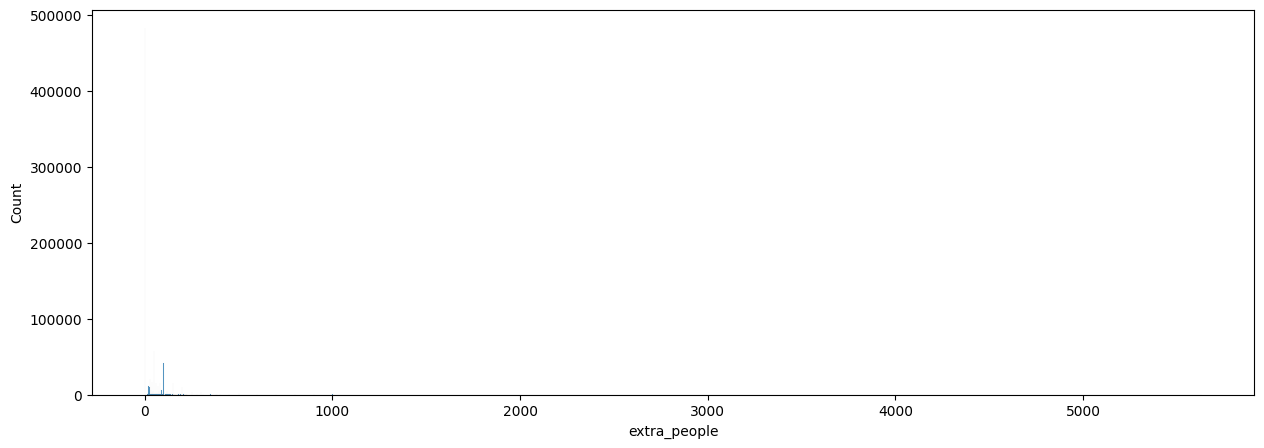

In [29]:
histograma(df1.extra_people) 

In [30]:
df1,linhas_removidas = excluir_outliers(df1,"extra_people")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 59194


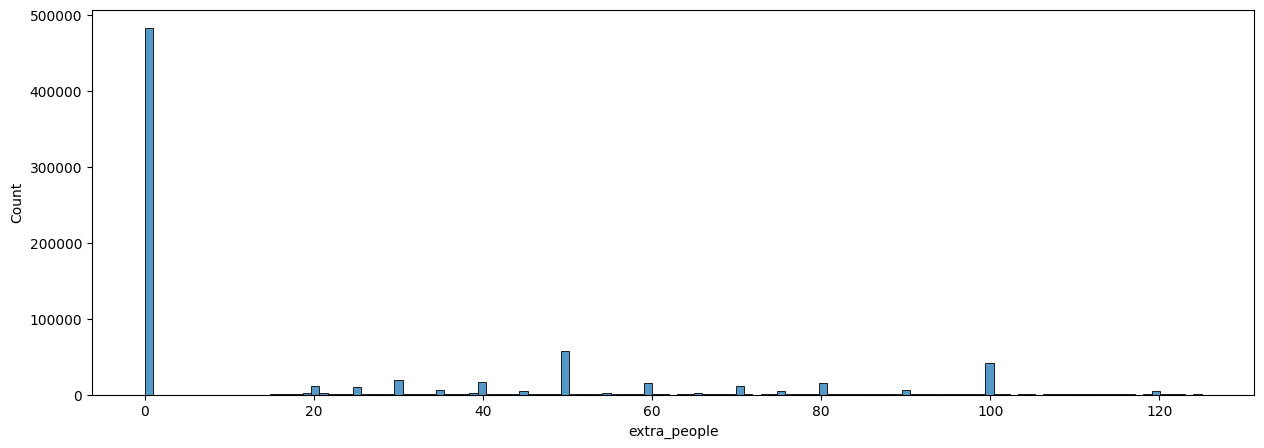

In [31]:
histograma(df1.extra_people) 

## 1.7.3 host_listings_cout

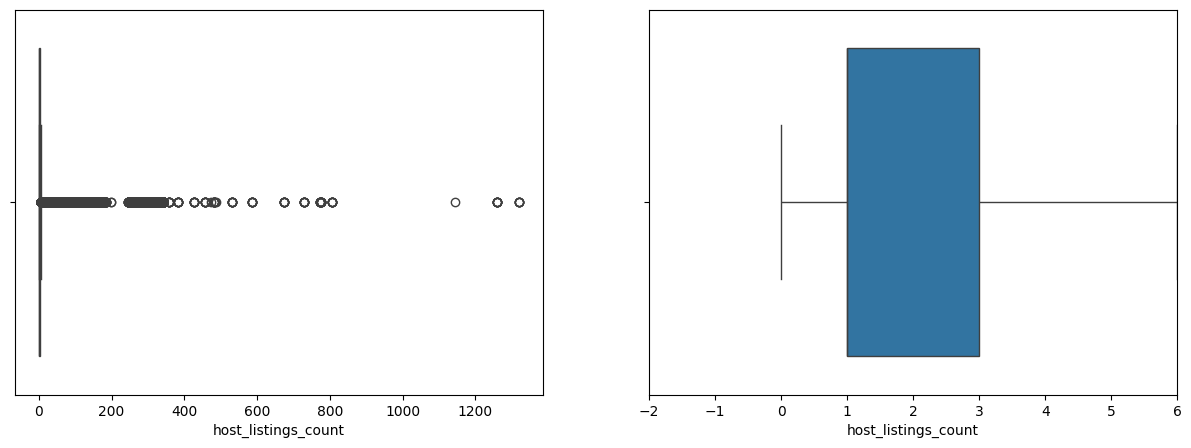

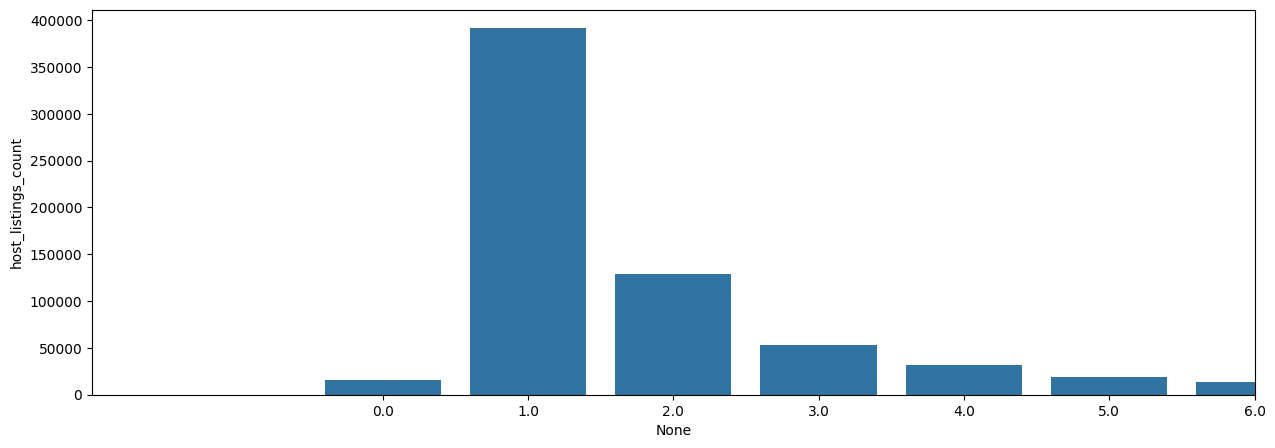

In [32]:
diagrama_caixa(df1.host_listings_count)
grafico_barras(df1.host_listings_count)

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [33]:
df1,linhas_removidas = excluir_outliers(df1,"host_listings_count")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 97723


### 1.7.4 Accommodates

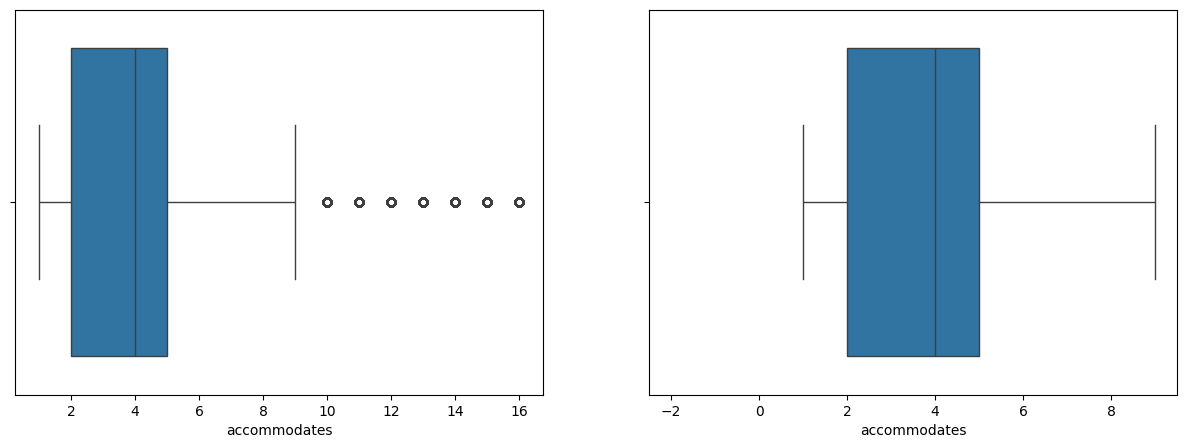

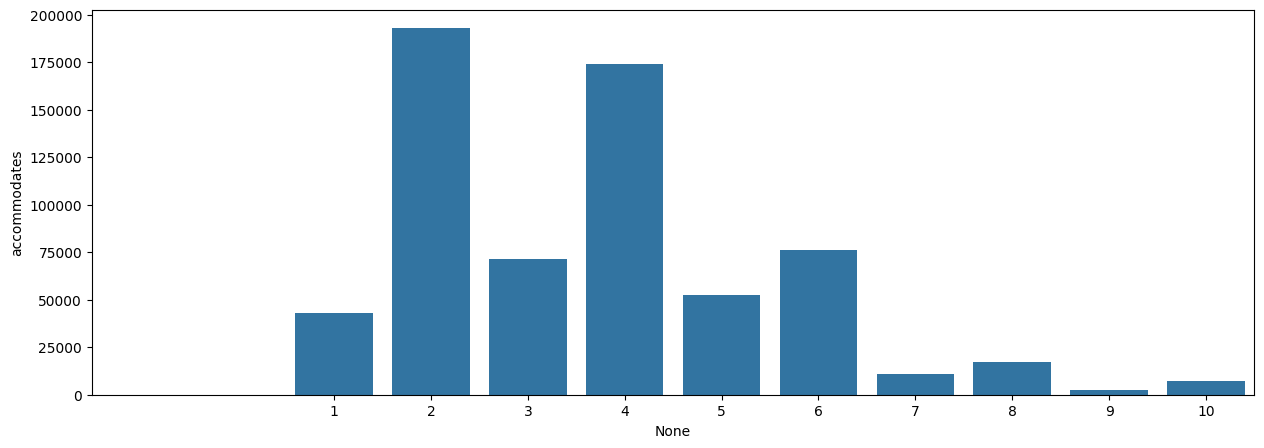

In [34]:
diagrama_caixa(df1.accommodates)
grafico_barras(df1.accommodates)

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [35]:
df1,linhas_removidas = excluir_outliers(df1,"accommodates")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 13146


### 1.7.5 Bathrooms                   

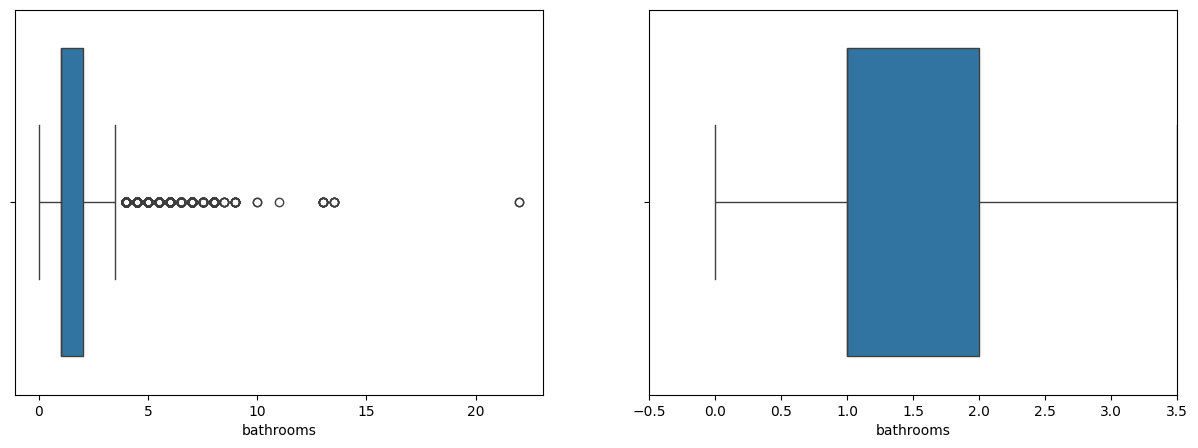

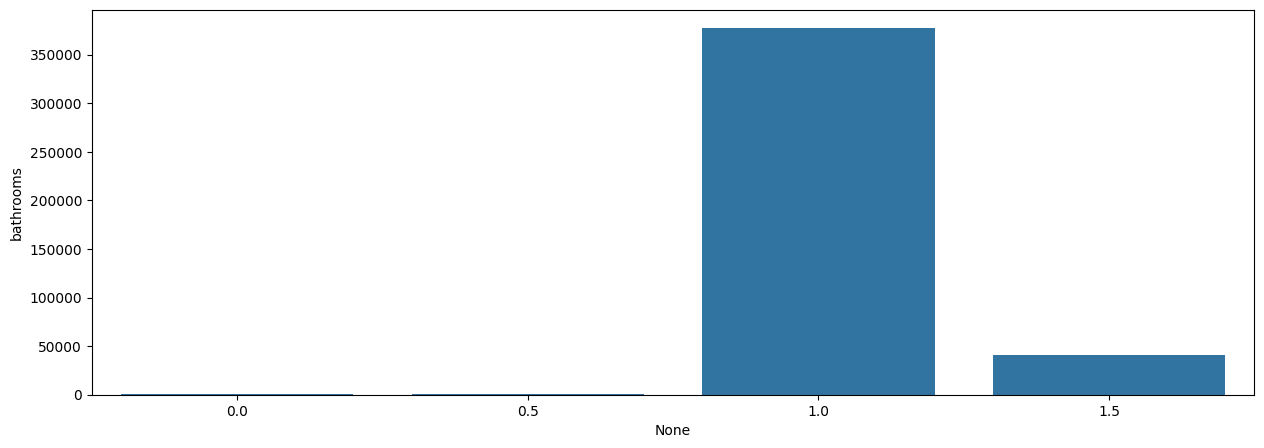

In [36]:
diagrama_caixa(df1.bathrooms)
grafico_barras(df1.bathrooms)

In [37]:
df1,linhas_removidas = excluir_outliers(df1,"bathrooms")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 6894


### 1.7.6 Bedrooms 

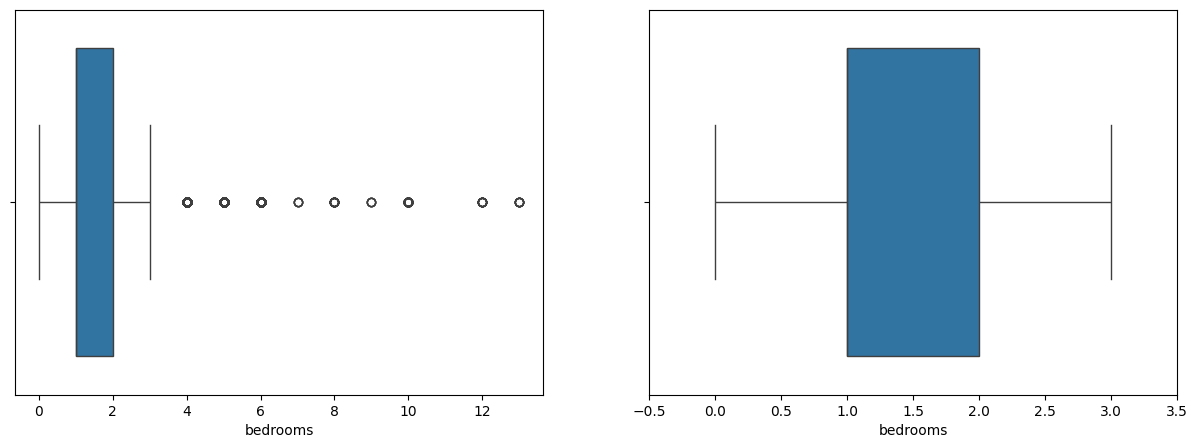

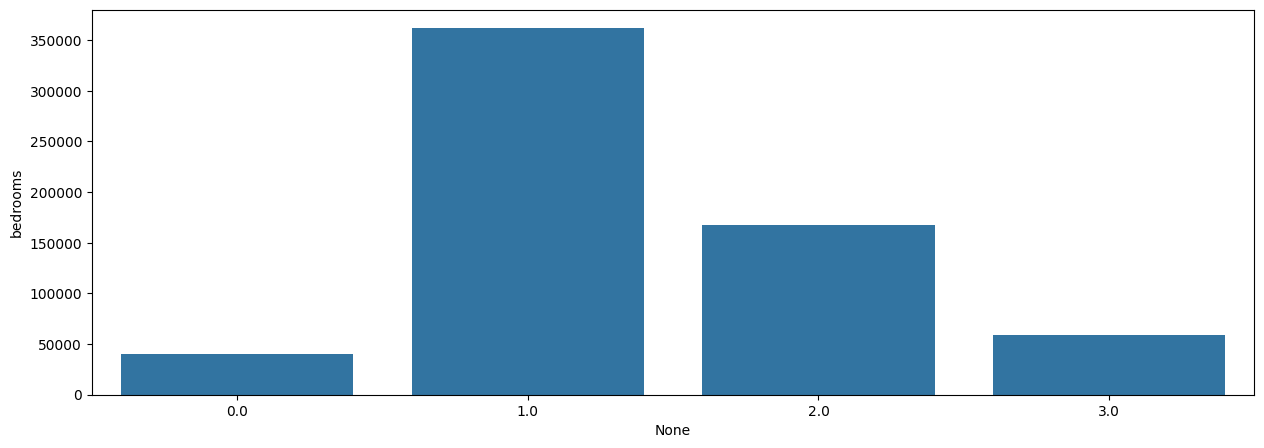

In [38]:
diagrama_caixa(df1.bedrooms)
grafico_barras(df1.bedrooms)

In [39]:
df1,linhas_removidas = excluir_outliers(df1,"bedrooms")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 5482


### 1.7.7 Beds

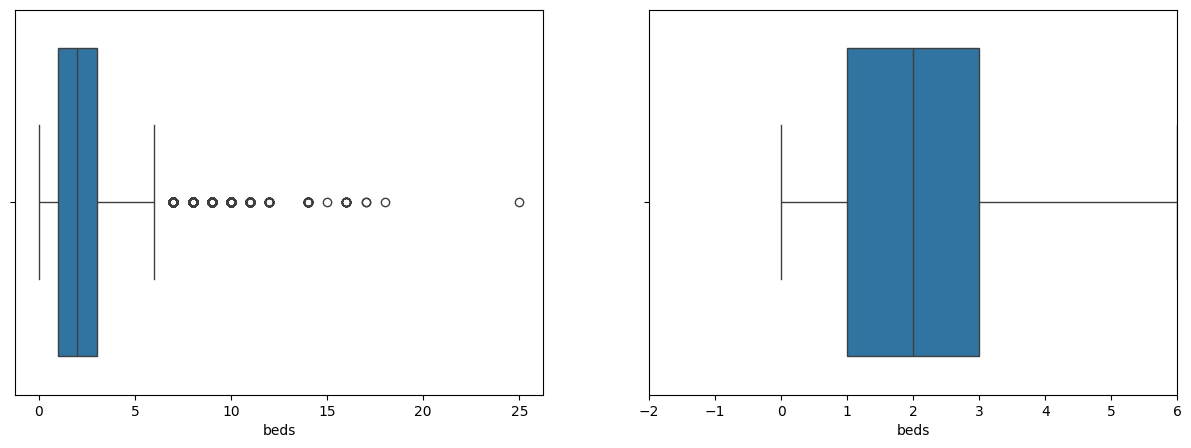

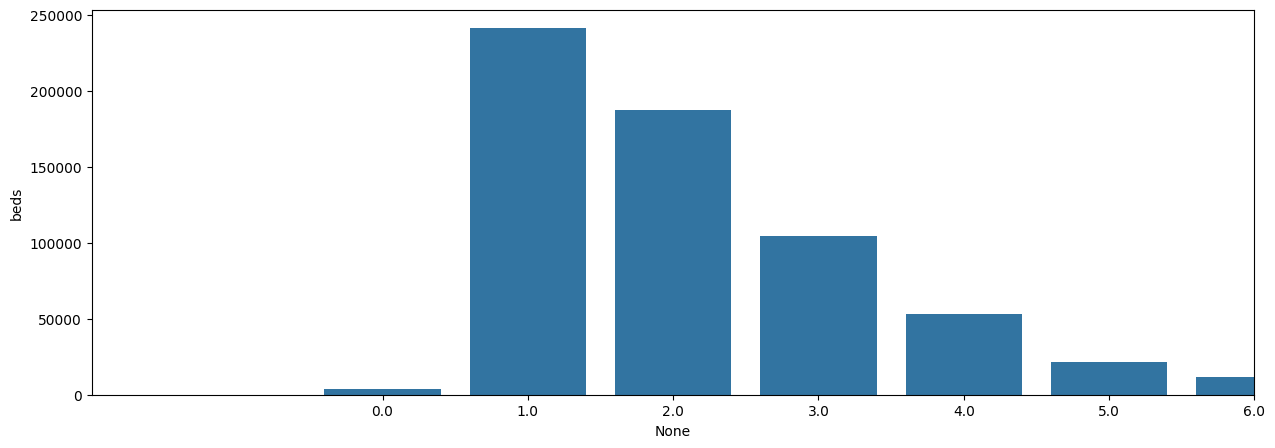

In [40]:
diagrama_caixa(df1.beds)
grafico_barras(df1.beds)

In [41]:
df1,linhas_removidas = excluir_outliers(df1,"beds")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 5622


### 1.7.8 Guests Included

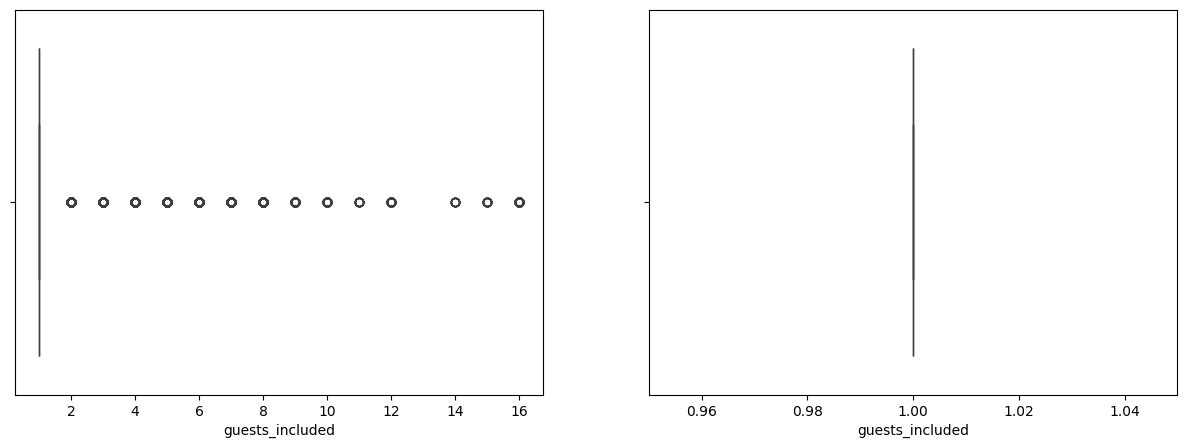

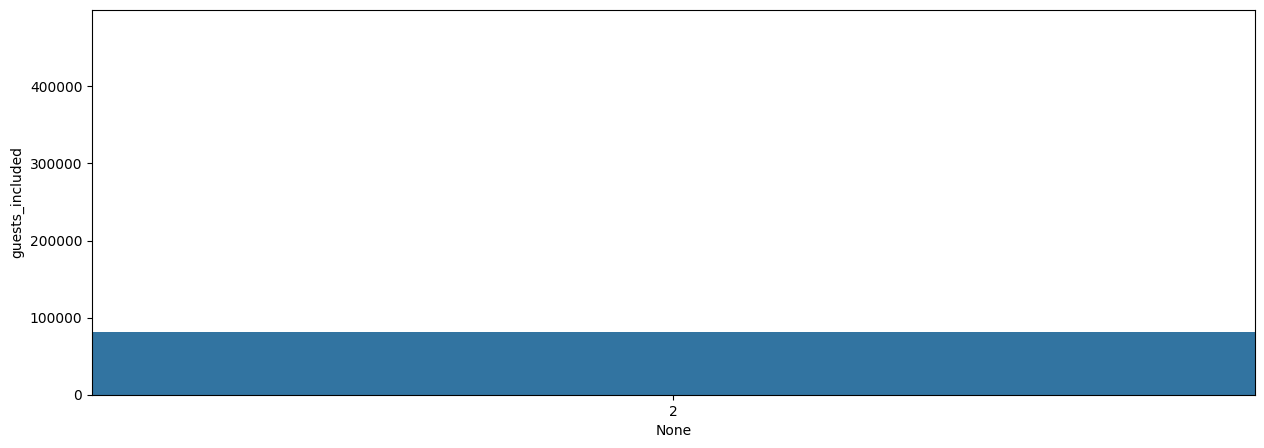

In [42]:
diagrama_caixa(df1.guests_included)
grafico_barras(df1.guests_included)

Vamos excluir a coluna guests_included pois temos muitos dados concentrados com 1 pessoa incluida na hora da locação da diaria e não relevante para previsão do preço.           

In [43]:
df1 = df1.drop(columns="guests_included",axis=1)
df1.shape

(622366, 22)

### 1.7.9 Minimum Nights

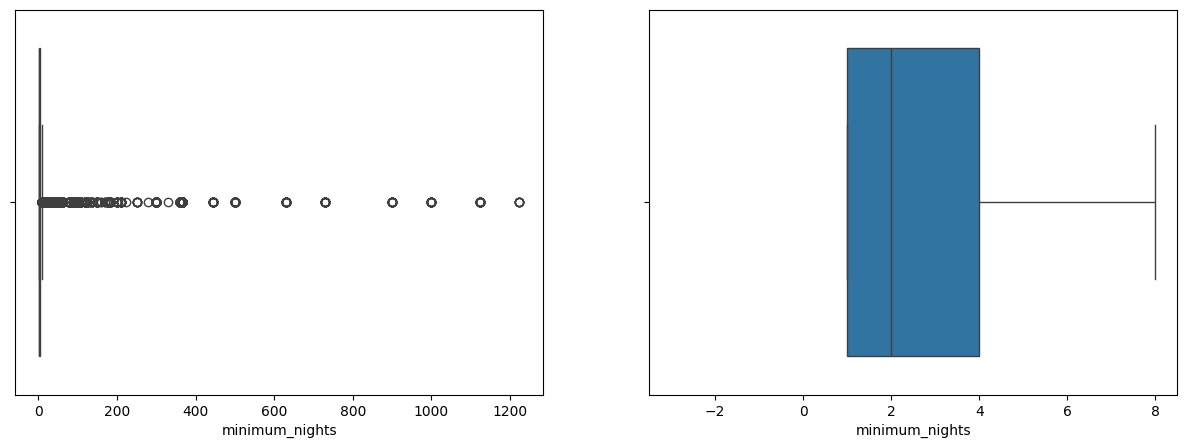

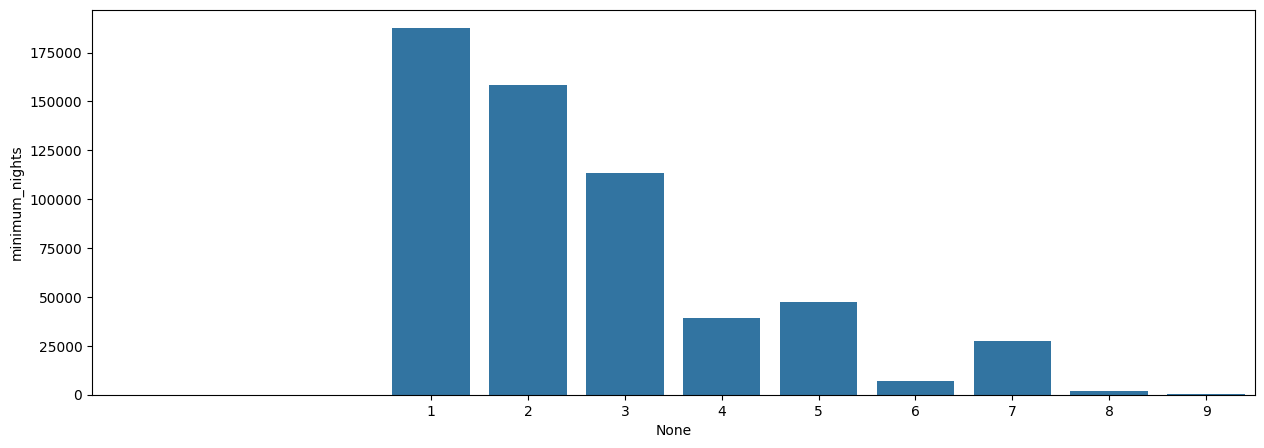

In [44]:
diagrama_caixa(df1.minimum_nights)
grafico_barras(df1.minimum_nights)

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [45]:
df1,linhas_removidas = excluir_outliers(df1,"minimum_nights")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 40383


### 1.7.10 Maximum Nights

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

### 1.7.11 Number Reviews   

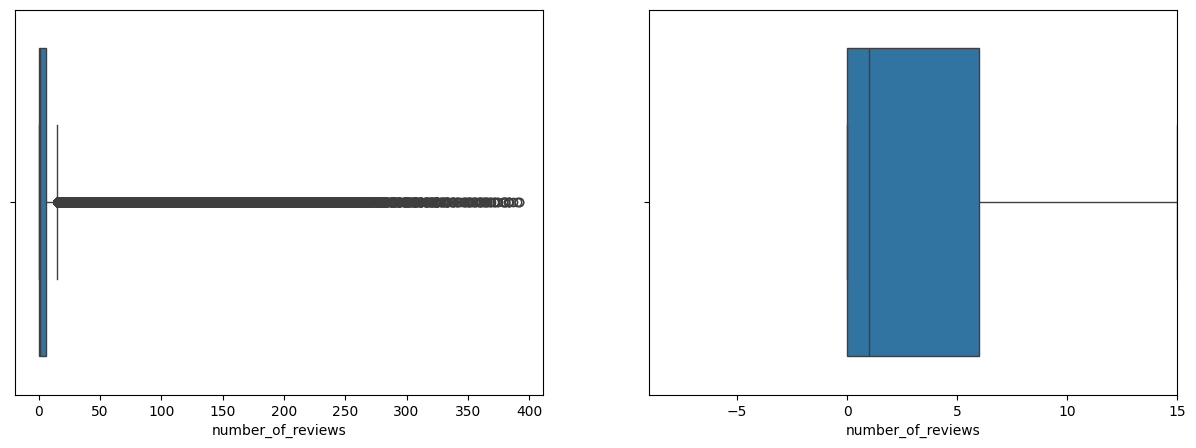

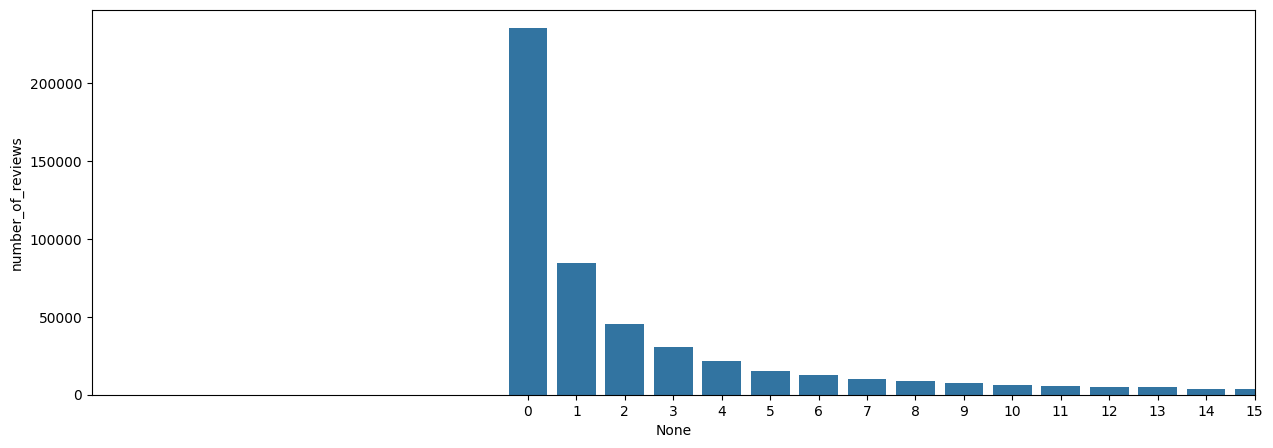

In [46]:
diagrama_caixa(df1['number_of_reviews'])
grafico_barras(df1['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [47]:
df1 = df1.drop(columns="number_of_reviews",axis=1)
df1.shape

(581983, 21)

# 2.0 Tratamento de Colunas Object(Valores de Texto)

In [48]:
colunas_object = df1.select_dtypes(include="object")
colunas_object.dtypes

host_is_superhost           object
property_type               object
room_type                   object
bed_type                    object
amenities                   object
has_availability            object
instant_bookable            object
is_business_travel_ready    object
cancellation_policy         object
dtype: object

## 2.0.1 Property Type

In [49]:
df1.property_type.value_counts()

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

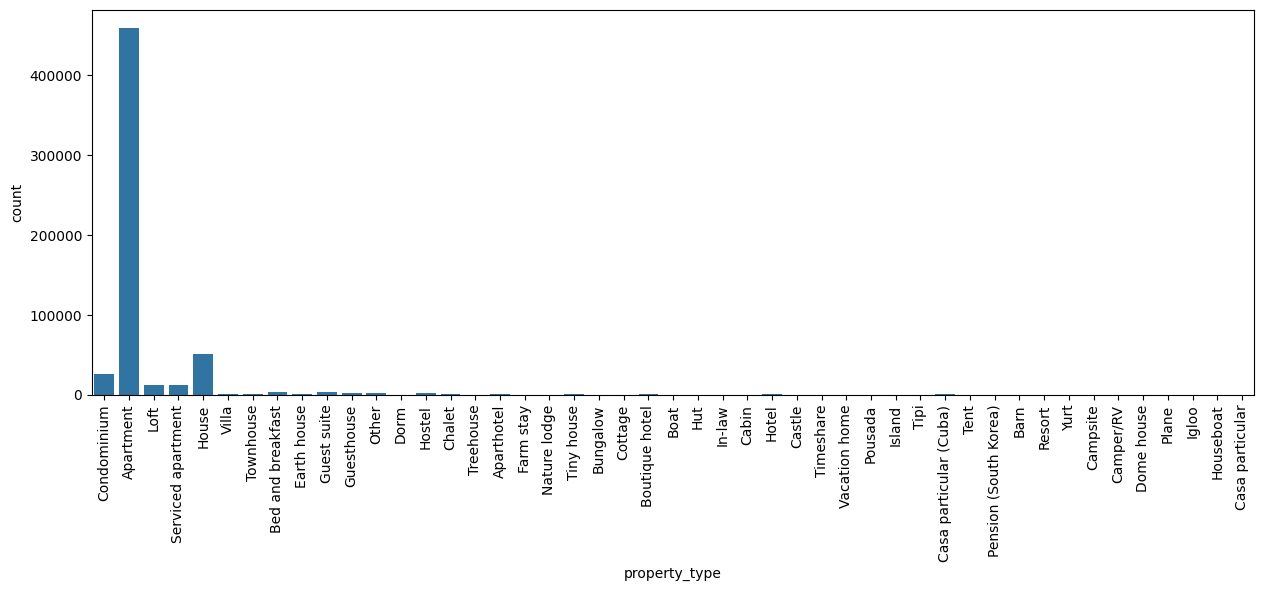

In [50]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=df1)
grafico.tick_params(axis='x', rotation=90)
plt.show()

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo

In [51]:
tabela_tipo_casas = df1["property_type"].value_counts()
colunas_agrupar=[]
for tipo in tabela_tipo_casas.index:
    if tabela_tipo_casas[tipo] < 10000:
        colunas_agrupar.append(tipo)
colunas_agrupar
for tipo in colunas_agrupar:
    #print(tipo)
    df1.loc[df1["property_type"]==tipo,"property_type"] = "Outros"
df1["property_type"].value_counts()

Apartment             458354
House                  51387
Condominium            26456
Outros                 20763
Serviced apartment     12671
Loft                   12352
Name: property_type, dtype: int64

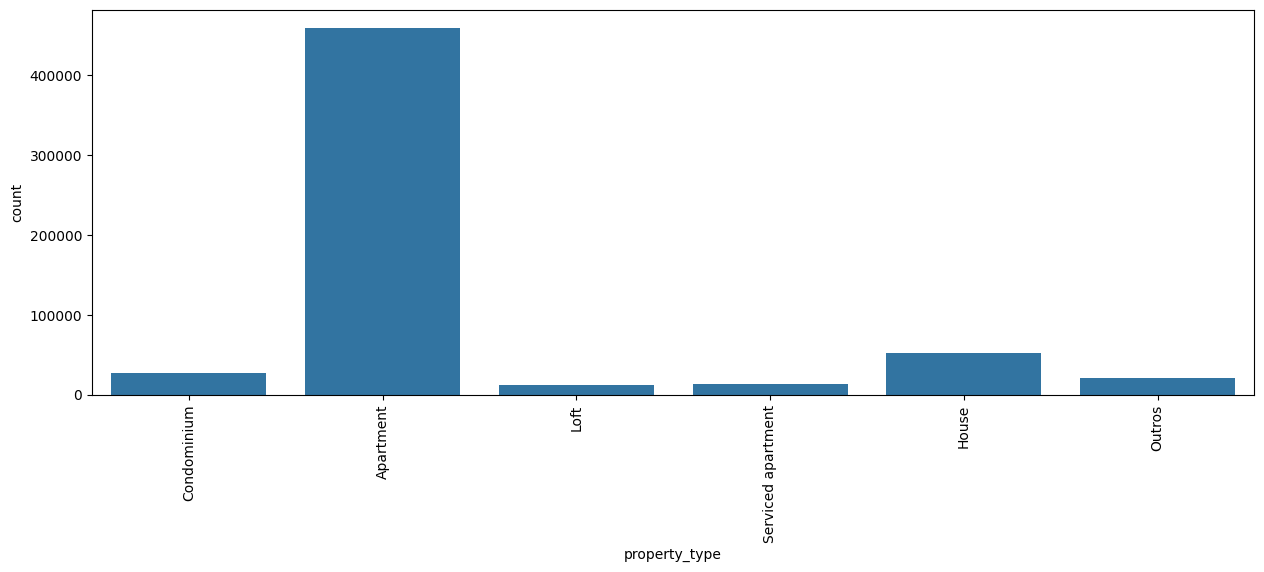

In [52]:
plt.figure(figsize=(15,5))
grafico =sns.countplot(x="property_type",data=df1) 
grafico.tick_params(axis='x',rotation=90)
plt.show();

## 2.0.2 Room Type

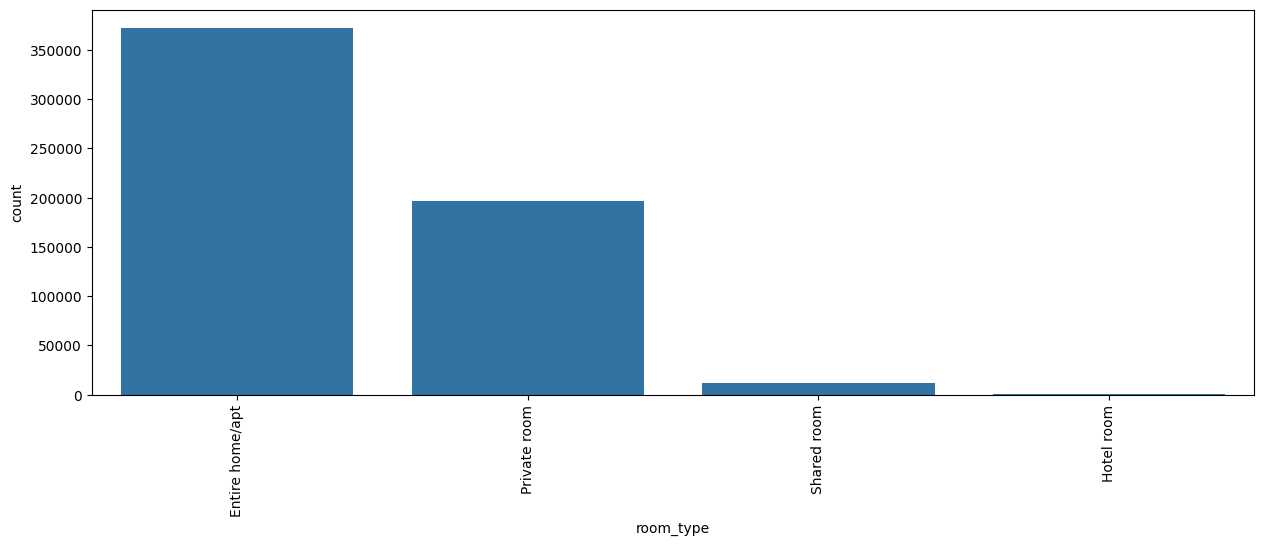

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64

In [53]:
plt.figure(figsize=(15,5))
grafico = sns.countplot(x="room_type",data=df1)
grafico.tick_params(axis="x",rotation=90)
plt.show()
df1.room_type.value_counts()

## 2.0.3 Bed Type

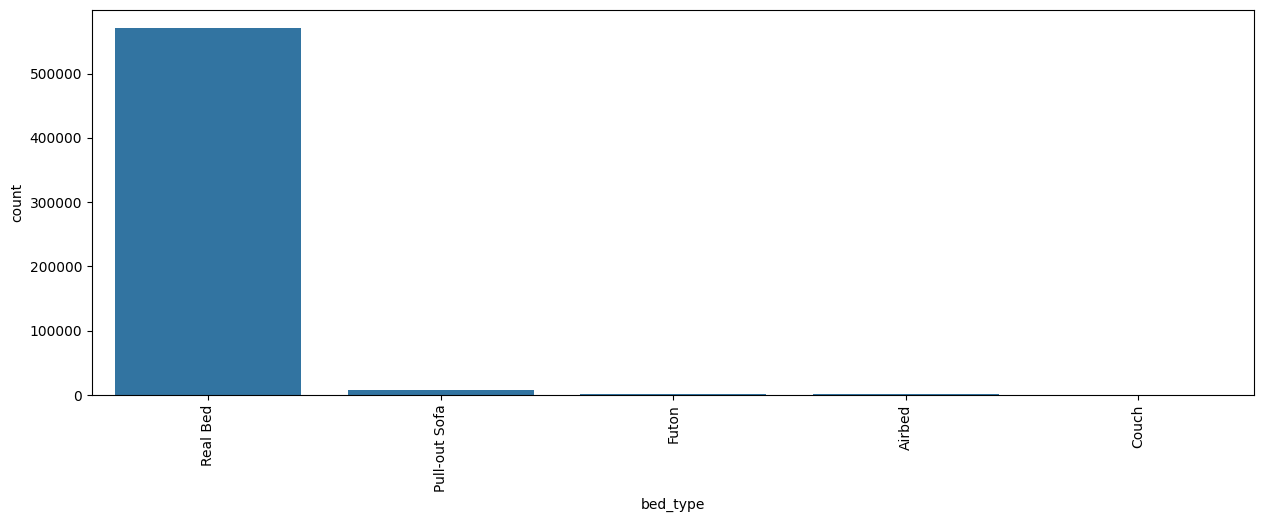

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64

In [54]:
plt.figure(figsize=(15,5))
grafico = sns.countplot(x="bed_type",data=df1)
grafico.tick_params(axis="x",rotation=90)
plt.show()
df1.bed_type.value_counts()

In [55]:
tipo_de_camas = df1.bed_type.value_counts()
colunas_agrupar=[]
for tipo in tipo_de_camas.index:
    #print(tipo)
    if tipo_de_camas[tipo] < 10000:
        colunas_agrupar.append(tipo)
colunas_agrupar        
for tipo in colunas_agrupar:
    df1.loc[df1["bed_type"] ==tipo,"bed_type"] = "Outros"
df1.bed_type.value_counts()

Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64

## 2.0.4 Cancellation Policy

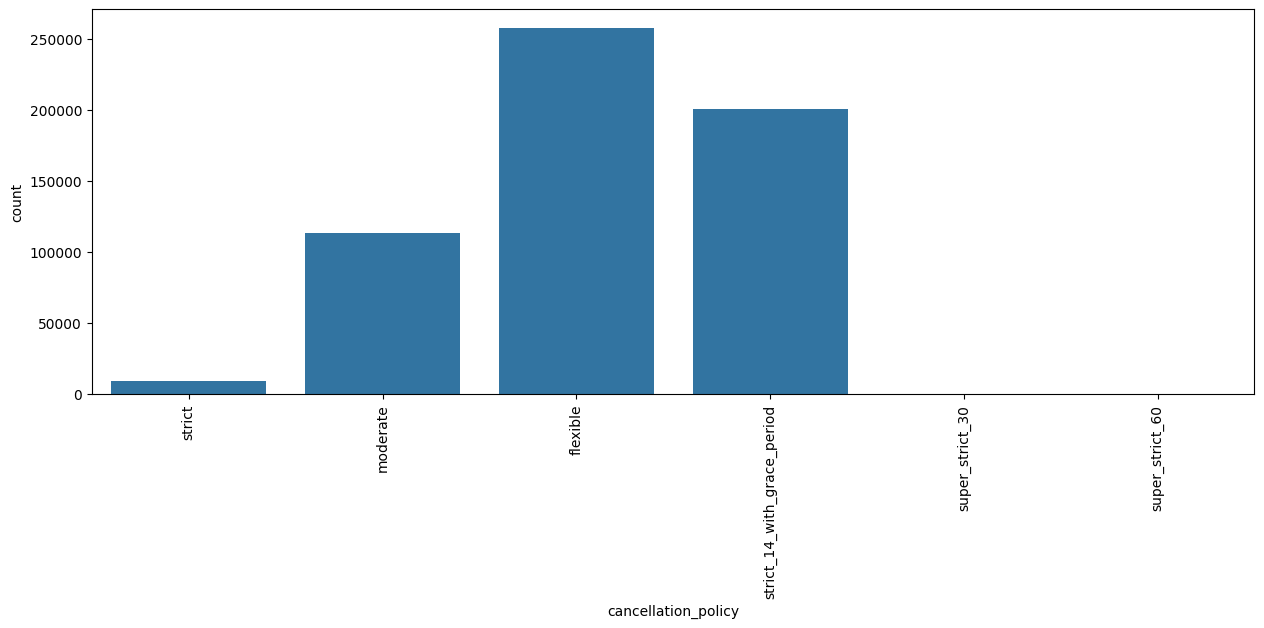

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64

In [56]:
plt.figure(figsize=(15,5))
grafico=sns.countplot(x="cancellation_policy",data=df1)
grafico.tick_params(axis="x",rotation=90)
plt.show()
df1.cancellation_policy.value_counts()

In [57]:
tipos_politica_cancelamento = df1.cancellation_policy.value_counts()
colunas_agrupar=[]
for tipo in tipos_politica_cancelamento.index:
    #print(tipo)
    if tipos_politica_cancelamento[tipo] <10000:
       colunas_agrupar.append(tipo)
colunas_agrupar
for tipo in colunas_agrupar:
    df1.loc[df1["cancellation_policy"]==tipo,"cancellation_policy"] ="strict"
df1.cancellation_policy.value_counts()


flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64

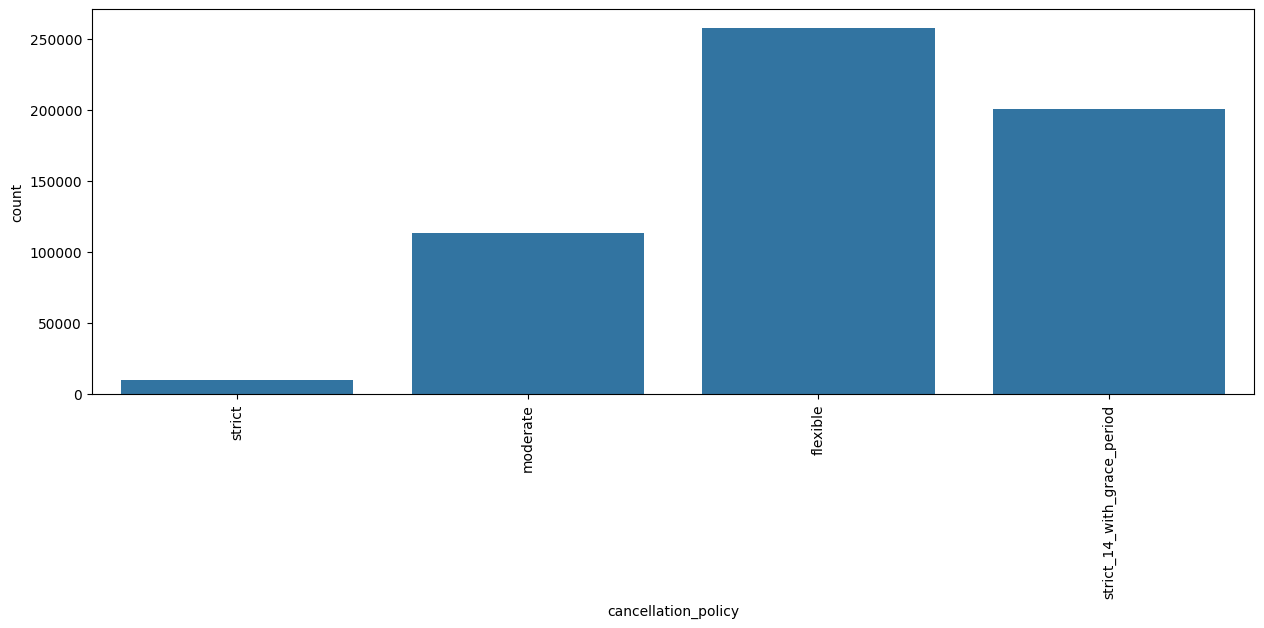

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64

In [58]:
plt.figure(figsize=(15,5))
grafico=sns.countplot(x="cancellation_policy",data=df1)
grafico.tick_params(axis="x",rotation=90)
plt.show()
df1.cancellation_policy.value_counts()

## 2.0.5 Amenities

In [59]:
df1["amenities"].head(2)

1    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
3    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
Name: amenities, dtype: object

In [60]:
df1["n_amenities"] = df1["amenities"].str.split(",").apply(len)
df1.head(2)

host_is_superhost  host_listings_count   latitude  longitude property_type  \
1                 t                  2.0 -22.965919 -43.178962   Condominium   
3                 f                  3.0 -22.977117 -43.190454     Apartment   

         room_type  accommodates  bathrooms  bedrooms  beds  ...  price  \
1  Entire home/apt             5        1.0       2.0   2.0  ...  270.0   
3  Entire home/apt             3        1.0       1.0   2.0  ...  161.0   

  extra_people  minimum_nights  has_availability  instant_bookable  \
1         51.0               4                 t                 t   
3         45.0               4                 t                 f   

  is_business_travel_ready cancellation_policy mes   ano  n_amenities  
1                        f              strict   4  2018           25  
3                        f              strict   4  2018           14  

[2 rows x 22 columns]

In [61]:
df1 = df1.drop(columns="amenities",axis=1)
df1.shape

(581983, 21)

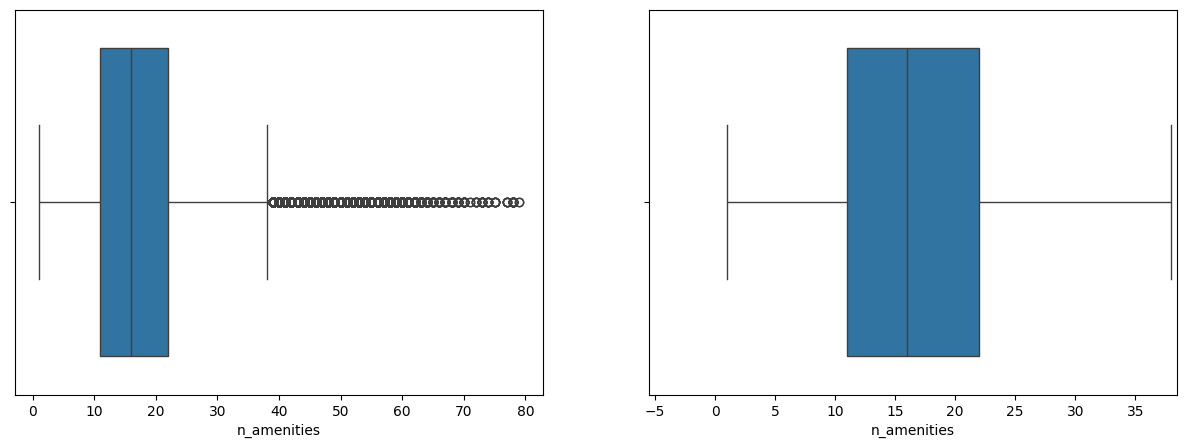

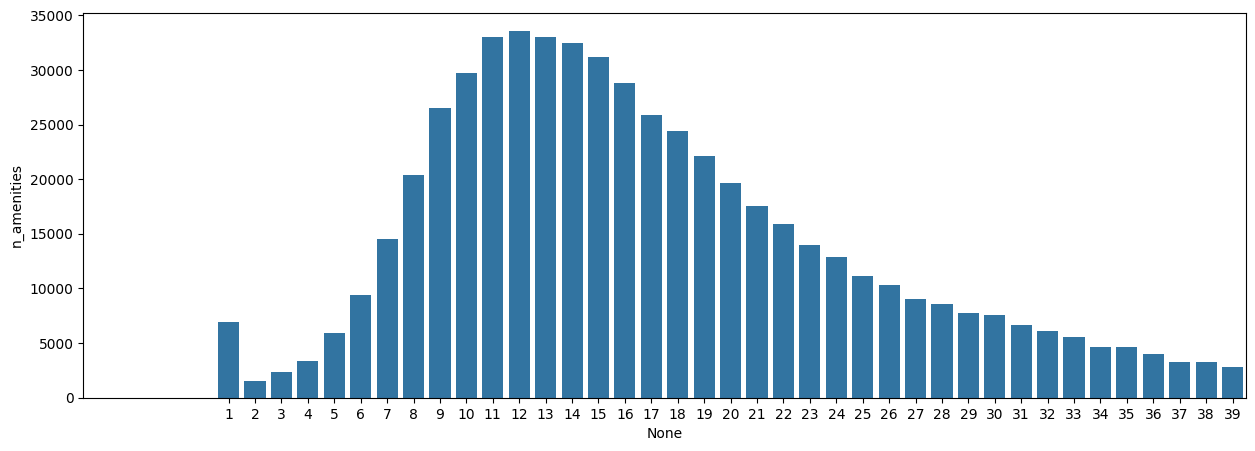

In [62]:
diagrama_caixa(df1.n_amenities)
grafico_barras(df1.n_amenities)

In [63]:
df1,linhas_removidas= excluir_outliers(df1,"n_amenities")
print(" A quantidade de linhas removidas foi de {}".format(linhas_removidas))

 A quantidade de linhas removidas foi de 24343


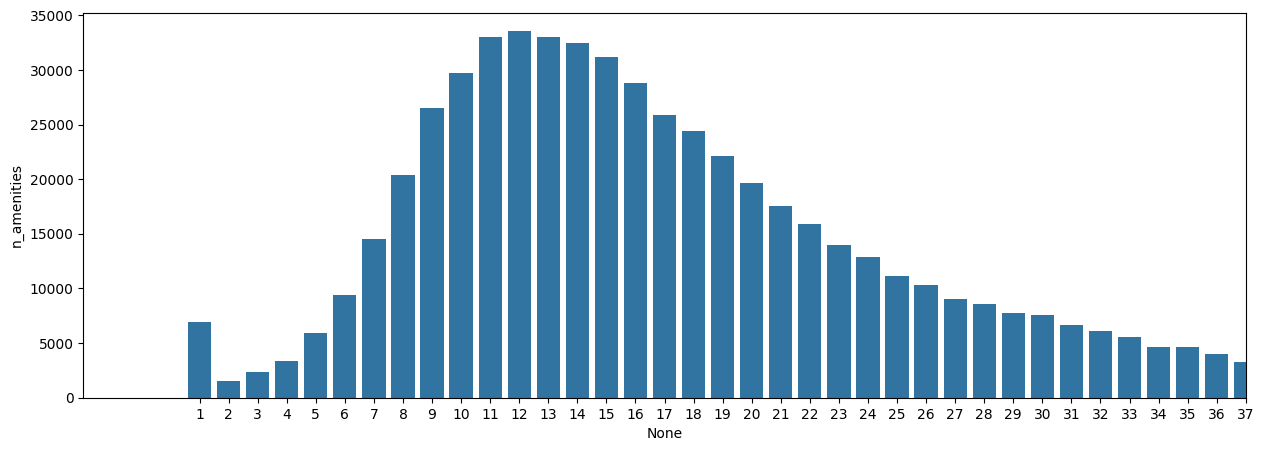

In [64]:
grafico_barras(df1.n_amenities)

### Visualização de Mapa das Propriedades

In [65]:
amostra = df1.sample(n=50000)
centro_mapa = {"lat":amostra.latitude.mean(),"lon":amostra.longitude.mean()}
mapa = px.density_mapbox(amostra,lat="latitude",lon="longitude",z="price",radius=2.5,
center=centro_mapa,zoom=10,mapbox_style="stamen-terrain")  
mapa.show()

# 3.0 Data Preparation

## 3.0.1 Encoding

In [66]:
categorical_cols = df1.select_dtypes(include="object")
categorical_cols.head(2)


host_is_superhost property_type        room_type  bed_type has_availability  \
1                 t   Condominium  Entire home/apt  Real Bed                t   
3                 f     Apartment  Entire home/apt  Real Bed                t   

  instant_bookable is_business_travel_ready cancellation_policy  
1                t                        f              strict  
3                f                        f              strict

In [67]:
colunas_label_encoder = ['host_is_superhost','has_availability','instant_bookable','is_business_travel_ready']


In [68]:
le =LabelEncoder()

In [69]:
for coluna in colunas_label_encoder:
    #print(coluna)
    df1[coluna] = le.fit_transform(df1[coluna])

In [70]:
df1[['host_is_superhost','has_availability','instant_bookable','is_business_travel_ready']].head()

host_is_superhost  has_availability  instant_bookable  \
1                  1                 0                 1   
3                  0                 0                 0   
4                  1                 0                 1   
5                  1                 0                 0   
6                  1                 0                 1   

   is_business_travel_ready  
1                         0  
3                         0  
4                         0  
5                         0  
6                         0

In [71]:
colunas_one_hot = ['property_type','room_type','bed_type','cancellation_policy']
df1 = pd.get_dummies(data=df1,columns=colunas_one_hot)

In [72]:
df1.head(2)

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                  1                  2.0 -22.965919 -43.178962             5   
3                  0                  3.0 -22.977117 -43.190454             3   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          1                     0                       0   
3                          1                     0                       0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  

[2 rows x 33 columns]

In [73]:
df1.shape

(557640, 33)

# 4.0 Split dataframe into training and test dataset

In [74]:
x = df1.drop(columns="price",axis=1)
y = df1.price


In [75]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y,test_size=0.3,random_state=7)

In [79]:
print(x_treino.shape,y_treino.shape)
print(x_teste.shape,y_teste.shape)

(390348, 32) (390348,)
(167292, 32) (167292,)


In [85]:
df_tratado = x.copy()
df_tratado["price"] = y
df_tratado.to_csv("base_tratada.csv")

# 5.0 MACHINE LEARNING MODELLING

In [80]:
maquina_preditiva_rl =LinearRegression()
maquina_preditiva_rf = RandomForestRegressor()
maquina_preditiva_et = ExtraTreesRegressor()
modelos = {"Regressão Linear":maquina_preditiva_rl,
          "Random Forest":maquina_preditiva_rf,
          "Extra Tree":maquina_preditiva_et}

In [78]:
for nome_modelo,modelo in modelos.items():
    #print(modelo)
    modelo.fit(x_treino,y_treino)
    previsoes = modelo.predict(x_teste)
    print(avaliar_modelo(nome_modelo,y_teste,previsoes))

Modelo Regressão Linear:
R2:0.325092683720663
RMSE:217.1427311552586
Modelo Random Forest:
R2:0.9700885252796397
RMSE:45.71325441481547
Modelo Extra Tree:
R2:0.9724505480258718
RMSE:43.87121982071361


In [76]:
model_et = ExtraTreesRegressor()
model_et.fit(x_treino,y_treino)
previsoes = model_et.predict(x_teste)

In [78]:
print(avaliar_modelo(model_et,y_teste,previsoes))

Modelo ExtraTreesRegressor():
R2:0.9724559835368112
RMSE:43.866891708146944


In [79]:
import joblib

joblib.dump(model_et,"model_et.joblib")

['model_et.joblib']

# 6.0 Feature Selection

In [ ]:
model_et.feature_importances_

In [80]:
#print(maquina_preditiva_et.feature_importances_)
importancia_feature = pd.DataFrame(data=model_et.feature_importances_,index= x_treino.columns)

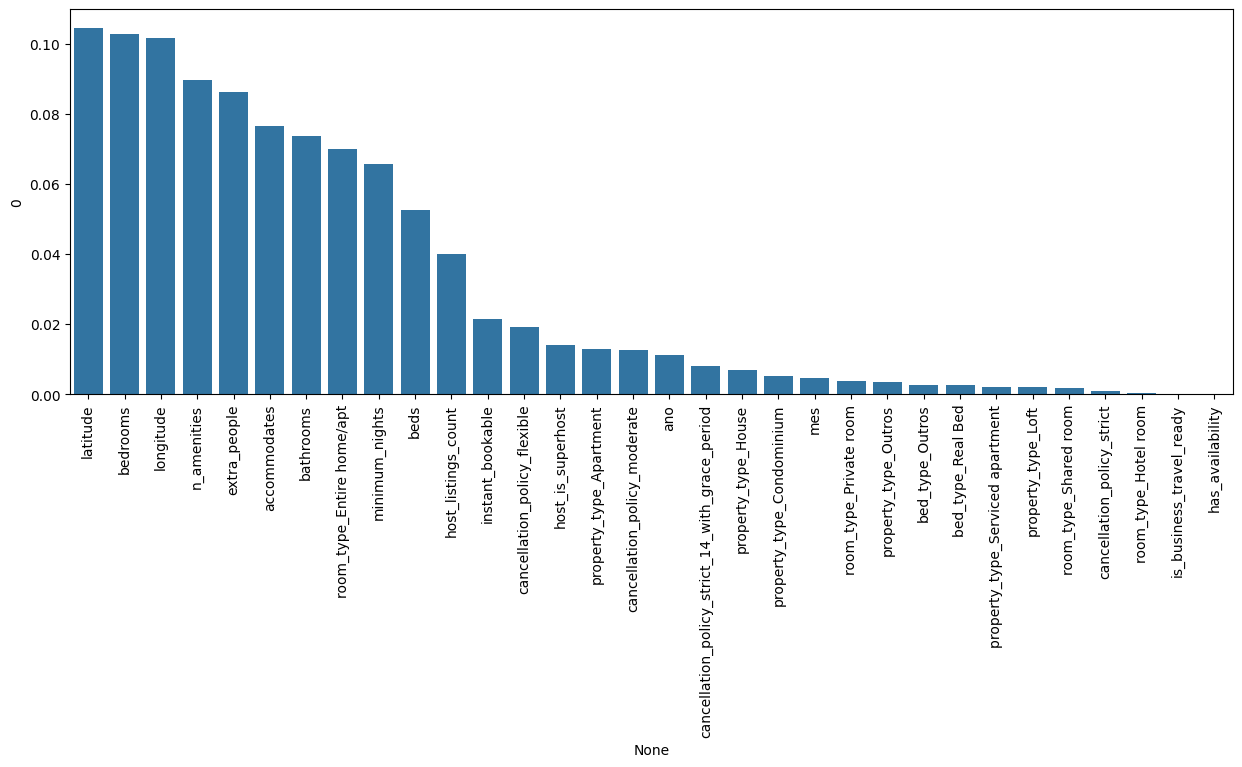

In [81]:
importancia_feature = importancia_feature.sort_values(by=0,ascending=False)
plt.figure(figsize=(15,5))
ax =sns.barplot(x=importancia_feature.index,y=importancia_feature[0])
ax.tick_params(axis="x",rotation=90)
plt.show()

In [46]:
import pandas as pd 
#df_teste = df1.copy()
df_teste = pd.read_csv("base_tratada.csv")
df_teste = df_teste.drop("Unnamed: 0",axis="columns")
df_teste.head(2)

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
0                  1                  2.0 -22.965919 -43.178962             5   
1                  0                  3.0 -22.977117 -43.190454             3   

   bathrooms  bedrooms  beds  extra_people  minimum_nights  ...  \
0        1.0       2.0   2.0          51.0               4  ...   
1        1.0       1.0   2.0          45.0               4  ...   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  \
0                     0                       0                      0   
1                     0                       0                      0   

   bed_type_Outros  bed_type_Real Bed  cancellation_policy_flexible  \
0                0                  1                             0   
1                0                  1                             0   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                             0                           1   
1                             0                           1   

   cancellation_policy_strict_14_with_grace_period  price  
0                                                0  270.0  
1                                                0  161.0  

[2 rows x 33 columns]

In [47]:
#df_teste.columns[1:-1]
df_teste.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'has_availability', 'instant_bookable',
       'is_business_travel_ready', 'mes', 'ano', 'n_amenities',
       'property_type_Apartment', 'property_type_Condominium',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Outros', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period', 'price'],
      dtype='object')

In [48]:
colunas = ['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period']

In [49]:
df_teste = df_teste.drop(columns=["has_availability","is_business_travel_ready",'bed_type_Outros', 'bed_type_Real Bed'],axis=1)
df_teste.head(2)

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
0                  1                  2.0 -22.965919 -43.178962             5   
1                  0                  3.0 -22.977117 -43.190454             3   

   bathrooms  bedrooms  beds  extra_people  minimum_nights  ...  \
0        1.0       2.0   2.0          51.0               4  ...   
1        1.0       1.0   2.0          45.0               4  ...   

   property_type_Serviced apartment  room_type_Entire home/apt  \
0                                 0                          1   
1                                 0                          1   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  \
0                     0                       0                      0   
1                     0                       0                      0   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             0   

   cancellation_policy_strict  \
0                           1   
1                           1   

   cancellation_policy_strict_14_with_grace_period  price  
0                                                0  270.0  
1                                                0  161.0  

[2 rows x 29 columns]

In [50]:
df_teste.to_csv("dados.csv")

In [51]:
df_aux = pd.read_csv("dados.csv")
df_aux.head()

Unnamed: 0  host_is_superhost  host_listings_count   latitude  longitude  \
0           0                  1                  2.0 -22.965919 -43.178962   
1           1                  0                  3.0 -22.977117 -43.190454   
2           2                  1                  1.0 -22.983024 -43.214270   
3           3                  1                  1.0 -22.988165 -43.193588   
4           4                  1                  1.0 -22.981269 -43.190457   

   accommodates  bathrooms  bedrooms  beds  extra_people  ...  \
0             5        1.0       2.0   2.0          51.0  ...   
1             3        1.0       1.0   2.0          45.0  ...   
2             3        1.0       1.0   2.0          68.0  ...   
3             3        1.5       1.0   2.0          86.0  ...   
4             2        1.0       1.0   2.0          80.0  ...   

   property_type_Serviced apartment  room_type_Entire home/apt  \
0                                 0                          1   
1                                 0                          1   
2                                 0                          1   
3                                 0                          1   
4                                 0                          1   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  \
0                     0                       0                      0   
1                     0                       0                      0   
2                     0                       0                      0   
3                     0                       0                      0   
4                     0                       0                      0   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  \
0                           1   
1                           1   
2                           1   
3                           1   
4                           1   

   cancellation_policy_strict_14_with_grace_period  price  
0                                                0  270.0  
1                                                0  161.0  
2                                                0  222.0  
3                                                0  308.0  
4                                                0  219.0  

[5 rows x 30 columns]

In [52]:
x_dt = df_teste.drop("price",axis=1)
y_dt = df_teste.price

In [53]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x_dt,y_dt,test_size=0.3,random_state=7)

In [54]:
model_et = ExtraTreesRegressor()
model_et.fit(x_treino,y_treino)
previsoes = model_et.predict(x_teste)

In [55]:
avaliar_modelo(model_et,y_teste,previsoes) 

'Modelo ExtraTreesRegressor():\nR2:0.972286082773179\nRMSE:44.00197562904002'

In [ ]:
#'Modelo ExtraTreesRegressor():\nR2:0.9724975646983639\nRMSE:43.83376694436019'

# 7.0 Deploy 